In [1]:
import torch
print(torch.__version__)

import torch.nn as nn

import torchvision
from torchvision import datasets

import matplotlib.pyplot as plt
%matplotlib inline

from models import VariationalAutoEncoder
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
sns.set()

import pandas as pd

from utils import output_to_pil

1.7.0


In [2]:
mnist_trainset = datasets.MNIST(root="../data/", train=True,
                                download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                ]))

mnist_valid = datasets.MNIST(root="../data/", train=False,
                             download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                             ]))

In [3]:
model = VariationalAutoEncoder().to("cuda")
reconstruction_loss_fn = nn.MSELoss().to("cuda")
kl_loss_fn = lambda mu, log_var: -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=1, shuffle=False)
kl_factor = 1e-3

In [4]:
for epoch in range(200):

    train_loss = 0
    valid_loss = 0

    model.train()
    for images, labels in tqdm(dataloader, leave=False):
        optimizer.zero_grad()
        mu, log_var, output = model(images.to("cuda"))
        reconstruction_loss = reconstruction_loss_fn(output, images.to("cuda"))
        kl_loss = kl_loss_fn(mu, log_var) / images.size()[0]
        loss = reconstruction_loss + kl_factor * kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(dataloader)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, leave=False):
            mu, log_var, output = model(images.to("cuda"))
            reconstruction_loss = reconstruction_loss_fn(output, images.to("cuda"))
            kl_loss = kl_loss_fn(mu, log_var) / images.size()[0]
            loss = reconstruction_loss + kl_factor * kl_loss
            valid_loss += loss.item() / len(valid_loader)

    print(f"Epoch {epoch+1}: train_loss {train_loss}, valid_loss {valid_loss}")

Epoch 1: train_loss 0.06489112409750632, valid_loss 0.04988466760190211
Epoch 2: train_loss 0.04908423185547193, valid_loss 0.04752344992356393
Epoch 3: train_loss 0.047479700096448155, valid_loss 0.04651665723267935
Epoch 4: train_loss 0.046444335627555865, valid_loss 0.046079997308924724
Epoch 5: train_loss 0.045773098498582826, valid_loss 0.045175152039807175
Epoch 6: train_loss 0.04531515565713253, valid_loss 0.044925759791676095
Epoch 7: train_loss 0.04495509364803633, valid_loss 0.04478101774472742
Epoch 8: train_loss 0.04467551474968588, valid_loss 0.044406162514071944
Epoch 9: train_loss 0.044401665514707506, valid_loss 0.04432775689400709
Epoch 10: train_loss 0.04416394821604086, valid_loss 0.04444874182799829
Epoch 11: train_loss 0.04397870273391401, valid_loss 0.04417246420960875
Epoch 12: train_loss 0.043835000242789565, valid_loss 0.04424414213346285


KeyboardInterrupt: 

In [5]:
points = []
colors = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        mu, log_var = model.encoder(images.to("cuda"))
        points.append(mu.squeeze(0).cpu().detach().numpy())
        colors.append(labels[0].detach().numpy())

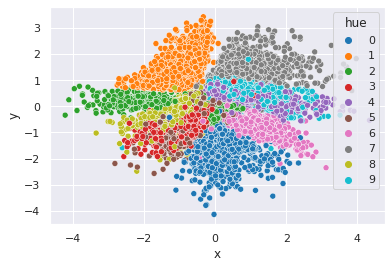

In [6]:
np_points = np.vstack(points)
np_colors = np.stack(colors).tolist()
data = pd.DataFrame({'x': np_points[:,0], 'y': np_points[:,1], 'hue': np_colors})
sns.scatterplot(x='x', y='y', hue='hue', data=data, palette="tab10")
plt.show()

In [11]:
output_to_pil(model(mnist_trainset[0][0].unsqueeze(0).cuda())[2])